In [44]:
import os
import sys
import subprocess
import numpy as np
import pandas as pd

from itertools import chain, product
from random import choice
from multiprocessing import Pool

import matplotlib.pyplot as plt
from scipy.misc import imread, imresize

-----------------------

### Geometries

In [13]:
# Random Geometry
def generate_random_rays(sample_size=100, height=20, width=20):
    x_bounds = []
    rays = []
    for _ in range(sample_size):
        start_horizontal = choice([True, False])    
        start_x = 0 if start_horizontal else choice(range(width))
        start_y = choice(range(height)) if start_horizontal else 0
        end_horizontal = choice([True, False])    
        end_x = width if end_horizontal else choice(range(width))
        end_y = choice(range(height)) if end_horizontal else height
        rays.append(((start_x, start_y), (end_x, end_y)))
    return rays

In [14]:
# Horizontal Geometry
def end_coor(y_s, alpha, rows, cols):
    x_end = 256
    if 0 <= alpha <= np.pi / 2:
        y_end = y_s + np.tan(alpha) * cols
    else:
        y_end = y_s - np.tan(abs(alpha)) * cols
    
    if y_end > rows:
        y_end = rows
        x_end = min(abs(y_end - y_s) / np.tan(alpha), rows)
    if y_end < 0:
        y_end = 0
        x_end = min(abs(y_end - y_s) / np.tan(abs(alpha)), rows)
    return x_end, y_end

def generate_rays_horizontal(im, h_resolution=20, a_resolution=10, alpha_min=-np.pi/2 , alpha_max=0):
    rays = []
    rows, cols = im.shape
    start_x = 0
    for start_y in np.linspace(0, rows, h_resolution):
        for angle in np.linspace(alpha_min, alpha_max, a_resolution):
            end_x, end_y = end_coor(start_y, angle, rows, cols)
            rays.append(((start_x, start_y), (end_x, end_y)))
    return rays

In [15]:
# Horizontal + vertival geometry
def end_coor_h(y_s, alpha, rows, cols):
    x_end = cols
    if 0 <= alpha <= np.pi / 2:
        y_end = y_s + np.tan(alpha) * cols
    else:
        y_end = y_s - np.tan(abs(alpha)) * cols
    
    if y_end > rows:
        y_end = rows
        x_end = min(abs(y_end - y_s) / np.tan(alpha), rows)
    if y_end < 0:
        y_end = 0
        x_end = min(abs(y_end - y_s) / np.tan(abs(alpha)), rows)
    return x_end, y_end

def end_coor_v(x_s, alpha, rows, cols):
    y_end = rows
    if 0 <= alpha <= np.pi / 2:
        x_end = x_s + np.tan(alpha) * rows
    else:
        x_end = x_s - np.tan(abs(alpha)) * rows
    
    if x_end > cols:
        x_end = cols
        y_end = min(abs(x_end - x_s) / np.tan(alpha), cols)
    if x_end < 0:
        x_end = 0
        y_end = min(abs(x_end - x_s) / np.tan(abs(alpha)), cols)
    return x_end, y_end

def generate_rays_hv(im, h_resolution=10, a_resolution=10, alpha_min=-np.pi/2 , alpha_max=0):
    rays = []
    rows, cols = im.shape
    start_x = 0
    for start_y in np.linspace(0, rows, h_resolution):
        for angle in np.linspace(alpha_min, alpha_max, a_resolution):
            end_x, end_y = end_coor_h(start_y, angle, rows, cols)
            rays.append(((start_x, start_y), (end_x, end_y)))
    
    start_y = 0
    for start_x in np.linspace(0, cols, h_resolution):
        for angle in np.linspace(alpha_min, alpha_max, a_resolution):
            end_x, end_y = end_coor_v(start_x, angle, rows, cols)
            rays.append(((start_x, start_y), (end_x, end_y)))        
    
    return rays

----------------------------------

### Recontruction

In [72]:
PARAMS_TO_FLAGS = {
    'input_file': '-i',
    'output_file': '-o',
    'rays': '-rays',
    'd_w': '-d_w',
    'd_h': '-d_h'
}

def output_to_dict(output):
    # Parsear la salida a un diccionario
    lines = output.decode().split('\n')
    d = dict(tuple(l.split(': ')) for l in lines if ': ' in l)
    return d

def run(exc_path, params):
    args = tuple(chain(*((PARAMS_TO_FLAGS[p], str(v)) for p, v in params.items())))
    args = [exc_path, *args]
    output = subprocess.check_output(args)
    return output_to_dict(output)


def run_grid_in_parallel(run_func, grid, n_proc=4):
    """Run a grid on n_proc workers"""
    done, results = 0, []
    
    def call_back(out):
        nonlocal done
        nonlocal results
        results.append(out)
        done += 1
        print('\r', f'Point {done}/{len(grid)} done', end='         ')
        sys.stdout.flush()

    with Pool(n_proc) as pool:
        for point in grid:
            kw = point
            imfile = kw.pop('imfile')
            pool.apply_async(run_func, (imfile, ), kw, callback=call_back)
            # call_back(run_func(imfile, **kw))
        pool.close()
        pool.join()
    return pd.DataFrame(results)

In [53]:
EXECUTABLE = '../codigo/build/tp3'
RAY_GENERATORS = {
    'random': generate_random_rays,
    'horizontal': generate_rays_horizontal, 
    'horizontal + vertical': generate_rays_hv
}

def rays_to_csv(outfname, rays_l):
    with open(outfname, 'w') as f:
        for ray in rays_l:
            f.write('{},{},{},{}\n'.format(ray[0][0], ray[0][1], 
                                         ray[1][0], ray[1][1]))

def reconstruction(imfile=None, generator_params=None, 
                   disc_h=25, disc_w=25,
                   ray_generator='random', 
                   outdir='../recursosTP3/results/',
                   outname='reconstruction', **kwargs):
    im = imread(imfile, 'L')
    rows, cols = im.shape
    rays = RAY_GENERATORS[ray_generator](im, **generator_params)
    rays_to_csv(outdir + '/' + outname + '_rays.csv', rays)
    params = {
        'input_file': imfile,
        'output_file': outdir + '/' + outname + '.png',
        'rays': outdir + '/' + outname + '_rays.csv',
        'd_w': str(disc_w),
        'd_h': str(disc_h),
    }
    run(EXECUTABLE, params)
    params['rays_generated'] = len(rays)
    params['generator'] = ray_generator
    params['generator_params'] = generator_params
    return params

In [54]:
i_file = '../recursosTP3/data/tomo.png'
o_dir = '../recursosTP3/results'
o_name = 'tomoreconstruction1'
ray_generator='horizontal'
ray_generator_params = {
    'h_resolution': 20,
    'a_resolution': 10,
    'alpha_min': -np.pi/2,
    'alpha_max': np.pi/2,
}
res = reconstruction(i_file, ray_generator_params,
               ray_generator='horizontal', 
               outdir=o_dir, outname=o_name)

/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


KeyboardInterrupt: 

In [26]:
res

{'input_file': '../recursosTP3/data/tomo.png',
 'output_file': '../recursosTP3/results/tomoreconstruction1.png',
 'rays': '../recursosTP3/results/tomoreconstruction1_rays.csv',
 'd_w': '25',
 'd_h': '25',
 'rays_generated': 200,
 'generator': 'horizontal',
 'generator_params': {'h_resolution': 20,
  'a_resolution': 10,
  'alpha_min': -1.5707963267948966,
  'alpha_max': 1.5707963267948966}}

/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


PSNR: 64.51221430724135


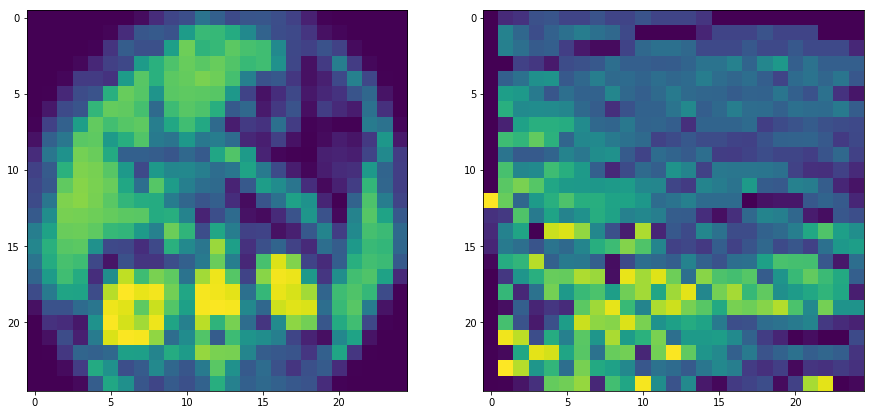

In [27]:
def psnr(u_0, u_1):
    rows, cols = u_0.shape
    N = rows * cols
    ecm = (1 / N)  * np.sum(np.power(u_1 - u_0, 2))
    return 10 * np.log(u_0.max() ** 2 / ecm)

def compute_error(original_imfile, reconstruction_imfile):
    original_im = imread(original_imfile, 'L')
    r_im = imread(reconstruction_imfile)
    r_rows, r_cols = r_im.shape
    original_resized = imresize(original_im, (r_rows, r_cols))
    error = psnr(r_im, original_resized)
    print(f"PSNR: {error}")
    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(original_resized)
    ax2.imshow(r_im)

compute_error(res['input_file'], res['output_file'])

Range of values

In [71]:
experiments  = {   
    f'h_resolution_at_{i}':{
            'imfile': '../recursosTP3/data/tomo.png',
            'outdir': '../recursosTP3/results',
            'outname': f'tomoreconstruction1_{i}',
            'ray_generator': 'horizontal',
            'generator_params': {
                'h_resolution': i,
                'a_resolution': 20,
                'alpha_min': -np.pi/2,
                'alpha_max': np.pi/2,
            }
        }
    for i in [10, 20, 50, 70, 100]
}

grid = experiments.values()
res = run_grid_in_parallel(reconstruction, grid)

/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


{'imfile': '../recursosTP3/data/tomo.png', 'outdir': '../recursosTP3/results', 'outname': 'tomoreconstruction1_10', 'ray_generator': 'horizontal', 'generator_params': {'h_resolution': 10, 'a_resolution': 20, 'alpha_min': -1.5707963267948966, 'alpha_max': 1.5707963267948966}}
{'imfile': '../recursosTP3/data/tomo.png', 'outdir': '../recursosTP3/results', 'outname': 'tomoreconstruction1_20', 'ray_generator': 'horizontal', 'generator_params': {'h_resolution': 20, 'a_resolution': 20, 'alpha_min': -1.5707963267948966, 'alpha_max': 1.5707963267948966}}
{'imfile': '../recursosTP3/data/tomo.png', 'outdir': '../recursosTP3/results', 'outname': 'tomoreconstruction1_50', 'ray_generator': 'horizontal', 'generator_params': {'h_resolution': 50, 'a_resolution': 20, 'alpha_min': -1.5707963267948966, 'alpha_max': 1.5707963267948966}}
{'imfile': '../recursosTP3/data/tomo.png', 'outdir': '../recursosTP3/results', 'outname': 'tomoreconstruction1_70', 'ray_generator': 'horizontal', 'generator_params': {'h_r

In [73]:
res

,d_h,d_w,generator,generator_params,input_file,output_file,rays,rays_generated
0,25,25,horizontal,"{'h_resolution': 10, 'a_resolution': 20, 'alph...",../recursosTP3/data/tomo.png,../recursosTP3/results/tomoreconstruction1_10.png,../recursosTP3/results/tomoreconstruction1_10_...,200
1,25,25,horizontal,"{'h_resolution': 20, 'a_resolution': 20, 'alph...",../recursosTP3/data/tomo.png,../recursosTP3/results/tomoreconstruction1_20.png,../recursosTP3/results/tomoreconstruction1_20_...,400
2,25,25,horizontal,"{'h_resolution': 50, 'a_resolution': 20, 'alph...",../recursosTP3/data/tomo.png,../recursosTP3/results/tomoreconstruction1_50.png,../recursosTP3/results/tomoreconstruction1_50_...,1000
3,25,25,horizontal,"{'h_resolution': 70, 'a_resolution': 20, 'alph...",../recursosTP3/data/tomo.png,../recursosTP3/results/tomoreconstruction1_70.png,../recursosTP3/results/tomoreconstruction1_70_...,1400
4,25,25,horizontal,"{'h_resolution': 100, 'a_resolution': 20, 'alp...",../recursosTP3/data/tomo.png,../recursosTP3/results/tomoreconstruction1_100...,../recursosTP3/results/tomoreconstruction1_100...,2000


In [75]:
f, axarr = plt.subplots(1, 2, figsize=(15,15))
axarr[0, 0].imshow(original_resized)
axarr[0, 1].imshow(res['output_file'].iloc[0])
axarr[0, 2].imshow(res['output_file'].iloc[0])

axarr[1, 0].imshow(res['output_file'].iloc[0])
axarr[1, 0].imshow(res['output_file'].iloc[0])


'../recursosTP3/results/tomoreconstruction1_10.png'